<h1>Trends from Data</h1>

<h2>Select Data</h2>

In [8]:
import numpy as np
import scipy
from pandas import DataFrame as df
import os
import ipywidgets as widgets
from ipywidgets import Button, Layout
import sys
import importlib
from importlib import reload
import yaml
import h5py
from lmfit import model, Model

sys.path.insert(0, '../src/')
import AnalysisTools
importlib.reload(AnalysisTools)
import XrayAnalysis
importlib.reload(XrayAnalysis)

dt = AnalysisTools.DataTools()

ParameterFolder = os.getcwd()[:-8] + '/Parameters'
FitsFolder = os.getcwd()[:-8] + '/Fits'


##### Plotly settings #####

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook+plotly_mimetype'
pio.templates.default = 'simple_white'
pio.templates[pio.templates.default].layout.update(dict(
    title_y = 0.95,
    title_x = 0.5,
    title_xanchor = 'center',
    title_yanchor = 'top',
    legend_x = 0,
    legend_y = 1,
    legend_traceorder = "normal",
    legend_bgcolor='rgba(0,0,0,0)',
    margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=50, #top margin
        )
));

##### Functions #####

def func(t,a,b,t0,sigma):
    return a*scipy.special.erf((t-t0)/sigma)+a+b

##### Button Functions #####

def UpdateFiles_Clicked(b):
    with open(ParameterFolder+'/'+ParameterFile.value+'.yaml', 'r') as stream:
        par = yaml.safe_load(stream)
    DataFile.options = dt.FileList(par['FolderPath'],[par['Runs']])

##### Widgets #####

ParameterFile = widgets.Dropdown(
    options=dt.FileList(ParameterFolder,['.yaml']),
    description='Parameter File',
    layout=Layout(width='70%'),
    style = {'description_width': '150px'},
    disabled=False,
)

UpdateFiles = widgets.Button(description="Update",layout = Layout(width='10%'))
UpdateFiles.on_click(UpdateFiles_Clicked)

with open(ParameterFolder+'/'+ParameterFile.value+'.yaml', 'r') as stream:
    par = yaml.safe_load(stream)

DataFile = widgets.Dropdown(
    options=dt.FileList(par['FolderPath'],[par['Runs']]),
    description='Data File',
    layout=Layout(width='50%'),
    style = {'description_width': '150px'},
    disabled=False,
)

display(widgets.Box([ParameterFile,UpdateFiles]))
display(DataFile)

Box(children=(Dropdown(description='Parameter File', layout=Layout(width='70%'), options=('CO-O-Ru Hor 2-1 - F…

Dropdown(description='Data File', layout=Layout(width='50%'), options=('XAS_014_014_D1000_E100.h5', 'XAS_014_0…

<h2>Trends</h2>

Scaling background by 1
Background Successfully subtracted from data


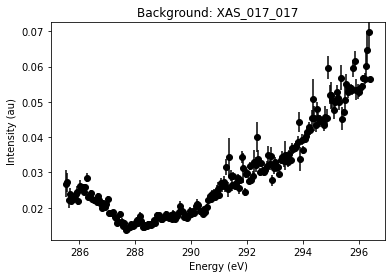

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

In [10]:
xray = XrayAnalysis.XrayTools([ParameterFolder,ParameterFile.value],DataFile.value)
xray.par['FolderPath'] + DataFile.value

Data = xray.Data
Data.columns = Data.columns + 100
Data.index = np.round(Data.index,2)
Data = dt.TrimData(Data,[286.6,289.1])

with open(ParameterFolder+'/'+ParameterFile.value+'.yaml', 'r') as stream:
    par = yaml.safe_load(stream)

DelayRange = par['Trends']['xRange']

par = par['Trends']['Data']

FitModel = Model(func)
FitParameters = FitModel.make_params()

Unpumped = Data.T[(Data.columns<-100)].T
Unpumped = Unpumped.mean(axis=1).values
Trends = Data.T

InitialPar = df(columns=['Assignment'])
for key in par :
    InitialPar.loc[par[key]['center']] = key

# Fit trends
fit_x = np.linspace(min(DelayRange), max(DelayRange), 1001)
fig = go.Figure()

FitsResults = list()
TrendFits = df(index=fit_x,columns=Trends.columns)
TrendParameters = df(index=['a','b','t0','sigma'],columns=Trends.columns)
Color = 5*px.colors.qualitative.Dark24

FitParameters['sigma'].min = 100
FitParameters['sigma'].max = 4000
FitParameters['t0'].min = 0
FitParameters['t0'].max = 4000
FitParameters['b'].min = 0

for idx,column in enumerate(Trends.columns) :
    index = InitialPar.index.get_loc(column,method='nearest')
    Assignment = InitialPar['Assignment'].values[index]
    FitParameters['a'].value = par[Assignment]['a']
    FitParameters['b'].value = par[Assignment]['b']
    FitParameters['t0'].value = par[Assignment]['t0']
    FitParameters['sigma'].value = par[Assignment]['sigma']
    y = Trends[column].values.astype('float64')
    t = Trends.index.values
    FitResults = FitModel.fit(y, FitParameters, t=t)
    FitsResults.append(FitResults)
    fit_y = FitResults.eval(t=fit_x)
    TrendFits[column] = fit_y
    TrendParameters[column] = np.array((FitResults.params['a'].value,FitResults.params['b'].value,FitResults.params['t0'].value,FitResults.params['sigma'].value))
    fig.add_trace(go.Scatter(x=fit_x,y=fit_y,mode='lines',showlegend = False,line_color=Color[idx]))
    fig.add_trace(go.Scatter(x=Trends.index,y=Trends[column],mode='markers',name=column,line_color=Color[idx]))

fig.update_layout(xaxis_title='Delay (fs)',yaxis_title='Change (%)',font_size=16,legend_title='',width=800,height=500)
fig.show()

TrendParameters = TrendParameters.T
display(TrendParameters)

# Plot sigma
Data2Plot = TrendParameters['sigma']
fig = px.scatter(Data2Plot)
fig.update_layout(xaxis_title='Energy (eV)',yaxis_title='Time (fs)',font_size=16,legend_title='',width=800,height=500)
fig.show()

# Plot t0
Data2Plot = TrendParameters['t0']
fig = px.scatter(Data2Plot)
fig.update_layout(xaxis_title='Energy (eV)',yaxis_title='Time (fs)',font_size=16,legend_title='',width=800,height=500)
fig.show()

# Plot data
fig = px.line(Data)
fig.show()

def DataSave2File_Clicked(b) :
    File = FitsFolder + '/' + ParameterFile.value + ' - ' + str.replace(DataFile.value,'.h5','') + ' - Trends.hdf'
    Trends.to_hdf(File,'Trends',mode='a')
    TrendFits.to_hdf(File,'TrendFits',mode='a')
    TrendParameters.to_hdf(File,'TrendParameters',mode='a')
    Data.to_hdf(File,'Data',mode='a')
    
DataSave2File = widgets.Button(description="Save to File")
DataSave2File.on_click(DataSave2File_Clicked)

display(DataSave2File)

<h2>Info</h2>

This script analyzes data from Fermi.

Uses:
- lmfit
- plotly

-----------------------
Created by Jerry LaRue, larue@chapman.edu, 9/2018

Last modified by Jerry LaRue, larue@chapman.edu, 01/2021